In [1]:
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#for classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_recall_fscore_support
from tabulate import tabulate

from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score

In [2]:
!pip install catboost
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [3]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

no_cat = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent',
    'Churn'
]

feature_cols = num_cols + cat_cols
col_count = len(feature_cols)
unique_cat = []
target_col = 'Churn'
error_col = 'TotalSpent'

In [4]:
# DATA IMPORT

data = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
# похоже в этом столбце некорректный формат данных
data[error_col] =  pd.to_numeric(data[error_col], errors='coerce')
data.fillna(1000., inplace=True)

# numeric data settings
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

In [5]:
# print(list(data[error_col]))

In [6]:
# DATASET SPLIT

y = data[target_col]

features_list = list(data)
features_list.remove(target_col)

X = data[features_list]
X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                                train_size=0.6, 
                                                                random_state=42)

# X_submis = X_submis.to_numpy()

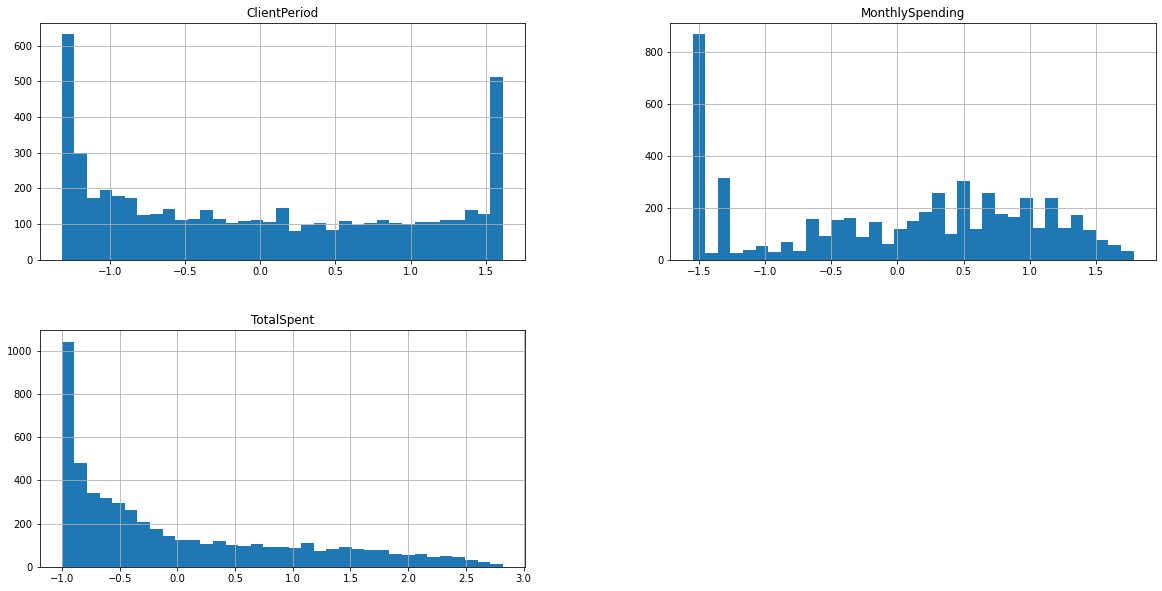

In [7]:
data[num_cols].hist(bins=35, figsize=(20, 10))
plt.show()

In [8]:
%%time

C_l = [10000, 1000, 100, 1, 0.1, 0.01, 0.001]

param_grid = {'iterations':[1000],
              'learning_rate':[0.01],
              'depth': [1, 3, 4, 6],
              'loss_function': ['Logloss', 'CrossEntropy'],
}
# clf = 
# preprocessing pipline for numeric data
# num_features = num_cols

# num_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=1.)),
#     ('numerical', StandardScaler())])

# использует трансвормеры на отдельных колонках
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', num_transformer, num_features),]
#         )


# pipe =  Pipeline(steps=[('preprocessor', preprocessor),
#                    ("catboostclf", CatBoostClassifier(cat_features=cat_cols, verbose=False))
#                    ])

search = GridSearchCV(CatBoostClassifier(cat_features=cat_cols, verbose=False), 
                      param_grid,
                      scoring='roc_auc',
                      cv=5,
                      refit=True)

search.fit(X_train, y_train)

CPU times: user 12min 44s, sys: 2min 2s, total: 14min 46s
Wall time: 4min 15s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f8a8c790850>,
             param_grid={'depth': [1, 3, 4, 6], 'iterations': [1000],
                         'learning_rate': [0.01],
                         'loss_function': ['Logloss', 'CrossEntropy']},
             scoring='roc_auc')

In [9]:
# model = CatBoostClassifier(cat_features=cat_cols, verbose=False)

# model.fit(X_train, y_train)
# model.get_params().keys()

In [10]:
# %%time
# search = model.grid_search(param_grid,
#                            X=X_train,
#                            y=y_train,
#                            plot=True)
# # search.fit(X_train, y_train)

In [11]:
search.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__verbose', 'estimator__cat_features', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [12]:
predictions = search.predict(X_validation)
predictions_probs = search.predict_proba(X_validation)[:, -1]

In [13]:
print("Tuned Hyperparameters :", search.best_params_)
print("Accuracy :",search.best_score_)

Tuned Hyperparameters : {'depth': 4, 'iterations': 1000, 'learning_rate': 0.01, 'loss_function': 'Logloss'}
Accuracy : 0.8546953177784443


In [14]:
X_validation.shape

(2113, 19)

In [15]:
predictions_probs.shape

(2113,)

In [16]:
roc_auc_score(y_validation, predictions_probs)

0.8321283934920298

In [17]:
X_submis = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')
X_submis[error_col] =  pd.to_numeric(X_submis[error_col], errors='coerce')
median = X_submis[error_col].sum()//len(X_submis[error_col])
# X_submis = X_submis.fillna(median)
X_submis.fillna(1., inplace=True)

X_submis[num_cols] = scaler.fit_transform(X_submis[num_cols])

In [18]:
predictions = search.predict(X_submis)
predictions_probs = search.predict_proba(X_submis)[:, -1]

In [19]:
new_df = pd.DataFrame(predictions_probs)
print(predictions_probs.shape)

(1761,)


In [20]:
submission = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv')
submission[target_col] = new_df
os.chdir('/kaggle/working/')
submission.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [21]:
pd.read_csv('/kaggle/working/submission.csv').head()

,Id,Churn
0,0,0.047097
1,1,0.719949
2,2,0.663543
3,3,0.013661
4,4,0.008497
